In [70]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from functools import reduce
from scipy.stats import pearsonr
from tqdm.notebook import tqdm
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

In [12]:
# Define the path to the 'free' subfolder
csv_folder_path = "processed_data"
csv_file_names = os.listdir(csv_folder_path)

wide_files = []
summary_files = []

# Loop through the filenames and read each "_wide" or "_summary" csv files
for file_name in csv_file_names:
    if "_wide" in file_name:
        # Construct the full file path
        wide_files.append(
            os.path.join(csv_folder_path, file_name)
        )
    elif "_summary" in file_name:
        # Construct the full file path
        summary_files.append(
            os.path.join(csv_folder_path, file_name)
        )

# Reading and storing dataframes in a list
dfs_wide = [pd.read_csv(file, on_bad_lines='skip', engine='python', sep=',') for file in wide_files]

print(dfs_wide[0].head(5))


          model_name  item_id       phenomenon        metric  \
0  google/flan-t5-xl        1        coherence  string_score   
1  google/flan-t5-xl        1          deceits  string_score   
2  google/flan-t5-xl        1           humour  string_score   
3  google/flan-t5-xl        1  indirect_speech  string_score   
4  google/flan-t5-xl        1            irony  string_score   

   sentence_cond_probs  mean_sentence_cond_probs  sentence_mi  \
0                    1                         1            1   
1                    1                         1            1   
2                    1                         0            0   
3                    0                         0            0   
4                    1                         1            0   

   sentence_surprisal  mean_sentence_surprisal  sentence_mi_surprisal  
0                   1                        1                      0  
1                   1                        1                      1  
2       

In [18]:
# Defining a function to merge two dataframes on 'model_name'
def merge_dfs(left, right):
    return pd.merge(left, right, on=['model_name','item_id','phenomenon', 'metric'], how='outer')

# Using reduce to apply the merge function to all dataframes in the list
df_wide = reduce(merge_dfs, dfs_wide)

# Concatenate all data into one DataFrame
df_summary = pd.concat([pd.read_csv(file, on_bad_lines='skip', engine='python', sep=',') for file in summary_files], ignore_index=True)

df_summary, len(df_summary)
#print(df_wide.head())


(            model_name      metric_formula       phenomenon       metric  \
 0    google/flan-t5-xl         sentence_mi        coherence  label_score   
 1    google/flan-t5-xl         sentence_mi          deceits  label_score   
 2    google/flan-t5-xl         sentence_mi           humour  label_score   
 3    google/flan-t5-xl         sentence_mi  indirect_speech  label_score   
 4    google/flan-t5-xl         sentence_mi            irony  label_score   
 ..                 ...                 ...              ...          ...   
 411   text-davinci-002  sentence_surprisal           humour  label_score   
 412   text-davinci-002  sentence_surprisal  indirect_speech  label_score   
 413   text-davinci-002  sentence_surprisal            irony  label_score   
 414   text-davinci-002  sentence_surprisal           maxims  label_score   
 415   text-davinci-002  sentence_surprisal         metaphor  label_score   
 
      dependent_variable  
 0              0.865000  
 1              0.21

In [153]:
# # Read the csv file into a pandas dataframe
df_string_scores = pd.read_csv(os.path.join(csv_folder_path, "string_scores_accuracy_summary.csv"))

# Subset the data by metric_formula == 'mean_sentence_cond_probs'
df_string_scores = df_string_scores[df_string_scores['metric_formula'] == 'mean_sentence_cond_probs'].reset_index(drop=True)
df_string_scores = df_string_scores.drop(columns=['metric_formula'])

print(df_string_scores)

                  model_name       phenomenon        metric  \
0          google/flan-t5-xl        coherence  string_score   
1          google/flan-t5-xl          deceits  string_score   
2          google/flan-t5-xl           humour  string_score   
3          google/flan-t5-xl  indirect_speech  string_score   
4          google/flan-t5-xl            irony  string_score   
5          google/flan-t5-xl           maxims  string_score   
6          google/flan-t5-xl         metaphor  string_score   
7     gpt-3.5-turbo-instruct        coherence  string_score   
8     gpt-3.5-turbo-instruct          deceits  string_score   
9     gpt-3.5-turbo-instruct           humour  string_score   
10    gpt-3.5-turbo-instruct  indirect_speech  string_score   
11    gpt-3.5-turbo-instruct            irony  string_score   
12    gpt-3.5-turbo-instruct           maxims  string_score   
13    gpt-3.5-turbo-instruct         metaphor  string_score   
14  meta-llama/Llama-2-7b-hf        coherence  string_s

In [20]:
# # Read the csv file into a pandas dataframe
df_label_scores = pd.read_csv(os.path.join(csv_folder_path, "label_scores_accuracy_bestConfigs_summary.csv"))


#df_label_scores = df_label_scores[df_label_scores['metric_formula'] == 'sentence_mi']
df_label_scores = df_label_scores.drop(columns=['metric_formula'])
print(df_label_scores)

                  model_name       phenomenon       metric  dependent_variable
0          google/flan-t5-xl        coherence  label_score            0.865000
1          google/flan-t5-xl          deceits  label_score            0.210000
2          google/flan-t5-xl           humour  label_score            0.328000
3          google/flan-t5-xl  indirect_speech  label_score            0.670000
4          google/flan-t5-xl            irony  label_score            0.320000
5          google/flan-t5-xl           maxims  label_score            0.263158
6          google/flan-t5-xl         metaphor  label_score            0.660000
7     gpt-3.5-turbo-instruct        coherence  label_score            0.640000
8     gpt-3.5-turbo-instruct          deceits  label_score            0.430000
9     gpt-3.5-turbo-instruct           humour  label_score            0.344000
10    gpt-3.5-turbo-instruct  indirect_speech  label_score            0.630000
11    gpt-3.5-turbo-instruct            irony  label

In [29]:
# Read the csv file into a pandas dataframe
df_free = pd.read_csv(os.path.join(csv_folder_path, "free_accuracy_summary.csv"))

# Repair zero values in the 'accuracy' column
# Creating a DataFrame for the new rows
new_rows = pd.DataFrame({
    'phenomenon': ['indirect_speech', 'humour'],
    'model_name': ['meta-llama/Llama-2-7b-hf', 'meta-llama/Llama-2-7b-hf'],
    'metric': ['free', 'free'],
    'dependent_variable': [0, 0]
})

# Concatenating the new rows to the existing DataFrame
df_free = pd.concat([df_free, new_rows], ignore_index=True)

# Displaying the updated DataFrame
print(df_free)

         phenomenon                model_name metric  dependent_variable
0         coherence         google/flan-t5-xl   free            0.800000
1         coherence    gpt-3.5-turbo-instruct   free            0.780000
2         coherence  meta-llama/Llama-2-7b-hf   free            0.287500
3         coherence          text-davinci-002   free            0.605000
4           deceits         google/flan-t5-xl   free            0.400000
5           deceits    gpt-3.5-turbo-instruct   free            0.800000
6           deceits  meta-llama/Llama-2-7b-hf   free            0.083333
7           deceits          text-davinci-002   free            0.660000
8            humour         google/flan-t5-xl   free            0.040000
9            humour    gpt-3.5-turbo-instruct   free            0.424000
10           humour          text-davinci-002   free            0.320000
11  indirect_speech         google/flan-t5-xl   free            0.550000
12  indirect_speech    gpt-3.5-turbo-instruct   fre

In [27]:
# Read the csv file into a pandas dataframe
df_rating = pd.read_csv(os.path.join(csv_folder_path, "rating_accuracy_summary.csv"))

# Repair zero values in the 'accuracy' column
# Creating a DataFrame for the new rows
new_rows = pd.DataFrame({
    'phenomenon': ['indirect_speech', 'deceits'],
    'model_name': ['google/flan-t5-xl', 'meta-llama/Llama-2-7b-hf'],
    'metric': ['rating', 'rating'],
    'dependent_variable': [0, 0]
})

# Concatenating the new rows to the existing DataFrame
df_rating = pd.concat([df_rating, new_rows], ignore_index=True)

# Displaying the updated DataFrame
print(df_rating)

                  model_name       phenomenon  dependent_variable  metric
0          google/flan-t5-xl        coherence            0.475000  rating
1          google/flan-t5-xl          deceits            0.050000  rating
2          google/flan-t5-xl           humour            0.240000  rating
3          google/flan-t5-xl            irony            0.480000  rating
4          google/flan-t5-xl           maxims            0.105263  rating
5          google/flan-t5-xl         metaphor            0.250000  rating
6     gpt-3.5-turbo-instruct        coherence            0.375000  rating
7     gpt-3.5-turbo-instruct          deceits            0.600000  rating
8     gpt-3.5-turbo-instruct           humour            0.400000  rating
9     gpt-3.5-turbo-instruct  indirect_speech            0.700000  rating
10    gpt-3.5-turbo-instruct            irony            0.440000  rating
11    gpt-3.5-turbo-instruct           maxims            0.421053  rating
12    gpt-3.5-turbo-instruct         m

In [31]:
# Import human data
# Define the path to the 'free' subfolder
human_folder_path = "../human_data"

# Recursively list all csv files in the 'free' folder
csv_files = []
for root, dirs, files in os.walk(human_folder_path):
    for file in files:
        if file.endswith(".csv"):
            csv_files.append(os.path.join(root, file))

# Concatenate all annotated csv files into a single dataframe
df_human = pd.concat([pd.read_csv(file) for file in csv_files], ignore_index=True)

PHENOMENA_LLM_LINK = {
    "HV": "humour", 
    "IV": "irony",
    "ISV": "indirect_speech",
    "DV": "deceits",
    "CIV": "coherence",
    "MV": "maxims",
    "MPV": "metaphor"
}

# Remap the "Task" column
df_human['Task'] = df_human['Task'].map(PHENOMENA_LLM_LINK)

# Display the unique values
print(df_human['Task'].unique())
      
# Return the first few rows of the concatenated dataframe and the number of non-annotated files
df_human.head(), len(df_human)


['deceits' 'indirect_speech' 'irony' 'humour' 'maxims' 'metaphor'
 'coherence']


(   Unnamed: 0  pKey  itemNum  Correct     Task OptionChosen
 0           1   100        9        1  deceits      Answer3
 1           2   100       16        1  deceits      Answer3
 2           3   100       14        1  deceits      Answer3
 3           4   100       17        0  deceits      Answer2
 4           5   100       13        1  deceits      Answer3,
 63580)

In [32]:
# Normalize df_human
# Group by 'phenomenon', 'model_name', and 'response_option', then compute the counts
aggregated_counts_human = df_human.groupby(['Task', 'Correct']).size().reset_index(name='count')

# Compute the total count for each combination of 'Task' and 'itemNum'
total_counts_human = df_human.groupby(['Task']).size().reset_index(name='total_count')

# Merge the dataframes on 'phenomenon' and 'model_name'
normalized_counts_human = pd.merge(aggregated_counts_human, total_counts_human, on=['Task'])

# Compute the normalized count
normalized_counts_human['normalized_count'] = normalized_counts_human['count'] / normalized_counts_human['total_count']

# Pivot the table for better visualization
normalized_counts_human_pivot = normalized_counts_human.pivot_table(index=['Task'], columns='Correct', values='normalized_count').fillna(0)

normalized_counts_human_pivot  # Displaying the first 10 rows for brevity


Correct,0,1
Task,,
coherence,0.143316,0.856684
deceits,0.158021,0.841979
humour,0.153155,0.846845
indirect_speech,0.114037,0.885963
irony,0.080535,0.919465
maxims,0.204144,0.795856
metaphor,0.103209,0.896791


In [33]:
# Reset index for the pivot table for plotting
normalized_counts_pivot_reset = normalized_counts_human_pivot.reset_index()

# Melt the DataFrame to have 'response_option' and 'normalized_count' as separate columns
melted_data = normalized_counts_pivot_reset.melt(id_vars=['Task'], 
                                                 value_vars=normalized_counts_human_pivot.columns, 
                                                 var_name='Correct', 
                                                 value_name='normalized_count')

# Filter out rows where normalized_count is zero to only plot non-zero responses
non_zero_melted_human_data = melted_data[(melted_data['normalized_count'] > 0) & (melted_data['Correct'] == True)]



# Rename the columns of human data
human_data_cleaned = non_zero_melted_human_data.copy()

human_data_cleaned.rename(columns={
    "Task": "phenomenon",
    "normalized_count": "dependent_variable"
}, inplace=True)
# Add two new columns with specified values
human_data_cleaned.loc[:,'model_name'] = 'human'
human_data_cleaned.loc[:,'metric'] = 'forced_choice'

# Drop column "Correct"
human_data_cleaned.drop(columns=['Correct'], inplace=True)
human_data_cleaned.reset_index(drop=True, inplace=True)

print(human_data_cleaned)

        phenomenon  dependent_variable model_name         metric
0        coherence            0.856684      human  forced_choice
1          deceits            0.841979      human  forced_choice
2           humour            0.846845      human  forced_choice
3  indirect_speech            0.885963      human  forced_choice
4            irony            0.919465      human  forced_choice
5           maxims            0.795856      human  forced_choice
6         metaphor            0.896791      human  forced_choice


In [59]:
# Define the list of metric values
model_names = ["google/flan-t5-xl", "gpt-3.5-turbo-instruct", "meta-llama/Llama-2-7b-hf", "text-davinci-002"]

# Duplicate df_human for each metric value and update the metric column
df_humans = [human_data_cleaned.copy().assign(model_name=model_name) for model_name in model_names]


# Concatenate all the dataframes together
df_human = pd.concat(df_humans, ignore_index=True)

# Rename metric column
df_human['metric'] = 'human'


df_human

,phenomenon,dependent_variable,model_name,metric
0,coherence,0.856684,google/flan-t5-xl,human
1,deceits,0.841979,google/flan-t5-xl,human
2,humour,0.846845,google/flan-t5-xl,human
3,indirect_speech,0.885963,google/flan-t5-xl,human
4,irony,0.919465,google/flan-t5-xl,human
5,maxims,0.795856,google/flan-t5-xl,human
6,metaphor,0.896791,google/flan-t5-xl,human
7,coherence,0.856684,gpt-3.5-turbo-instruct,human
8,deceits,0.841979,gpt-3.5-turbo-instruct,human
9,humour,0.846845,gpt-3.5-turbo-instruct,human


In [154]:
# Concat all three dataframes
df_all = pd.concat([df_label_scores, df_free, df_rating, df_human, df_string_scores], ignore_index=True)
df_all = df_all.reset_index(drop=True, inplace=False)
df_all

,model_name,phenomenon,metric,dependent_variable
0,google/flan-t5-xl,coherence,label_score,0.865000
1,google/flan-t5-xl,deceits,label_score,0.210000
2,google/flan-t5-xl,humour,label_score,0.328000
3,google/flan-t5-xl,indirect_speech,label_score,0.670000
4,google/flan-t5-xl,irony,label_score,0.320000
...,...,...,...,...
135,text-davinci-002,humour,string_score,0.080000
136,text-davinci-002,indirect_speech,string_score,0.050000
137,text-davinci-002,irony,string_score,0.240000
138,text-davinci-002,maxims,string_score,0.421053


In [155]:
print(df_all['model_name'].unique())

['google/flan-t5-xl' 'gpt-3.5-turbo-instruct' 'meta-llama/Llama-2-7b-hf'
 'text-davinci-002']


In [156]:
# Write CSV out
all_summary_out = os.path.join(csv_folder_path, "all_summary.csv")
df_all.to_csv(all_summary_out, index=False)


# Plot accuracy against phenomenon, facet by metrics, fill by model_name

In [157]:
PHENOMENA_PRETTY = {
    "humour": "Humor", 
    "irony": "Irony",
    "indirect_speech": "IndirectSpeech",
    "deceits": "Deceits",
    "coherence": "Coherence",
    "maxims": "Maxims",
    "metaphor": "Metaphor"
}
# Display before
print(df_all['phenomenon'].unique())

df_summary_plot = df_all.copy()
# Remap the "phenomenon" column
df_summary_plot['phenomenon'] = df_summary_plot['phenomenon'].map(PHENOMENA_PRETTY)

print(df_summary_plot['phenomenon'].unique())

CHANCE = {
    "Humor": 1/5,
    "Irony": 1/4,
    "IndirectSpeech": 1/4,
    "Deceits": 1/4,
    "Coherence": 1/2,
    "Maxims": 1/4,
    "Metaphor": 1/5
}


# Models and "pretty" names
print(df_summary_plot['model_name'].unique())

MODELS = {
    "google/flan-t5-xl": "Flan-T5 (XL)",
    "meta-llama/Llama-2-7b-hf": "Llama-2 (7B)",
    "gpt-3.5-turbo-instruct": "InstructGPT-3.5",
    "text-davinci-002": "text-davinci-002",
    "human": "Human"
}

MODEL_ORDER = [ 
    "Llama-2 (7B)", 
    "Flan-T5 (XL)", 
    "InstructGPT-3.5", 
    "text-davinci-002", 
    "Human"
] # sorted(MODELS.values()) 
ARTIFICIAL_MODELS = [m for m in MODEL_ORDER if m != "Human"]
SEEDS = range(5)

# Styling for visualizations
sns.set(style="white", font="Arial", font_scale=1.5)
paired = sns.color_palette("Paired")
PAL_MODEL = {
    "Human": paired[11], #"lightgrey",
    "InstructGPT-3.5": paired[0],
    "text-davinci-002": paired[1],
    "Flan-T5 (XL)": paired[7],
    "Llama-2 (7B)": paired[2],
}
PAL_METRIC = {
    "human": paired[11], #"lightgrey",
    "string_score": paired[0],
    "label_score": paired[1],
    "free": paired[7],
    "rating": paired[2],
}

ERR_STYLE = dict(errwidth=1, capsize=0.03)
CHANCE_STYLE = dict(color="k", ls="--", alpha=0.7, lw=2)

def render(outpath):
    plt.savefig(f"./plots/{outpath}", bbox_inches="tight", dpi=300)
    print(f"Rendered figure to {outpath}")

# Remap the "model_name" column
df_summary_plot['model_name'] = df_summary_plot['model_name'].map(MODELS)

print(df_summary_plot['model_name'].unique())


['coherence' 'deceits' 'humour' 'indirect_speech' 'irony' 'maxims'
 'metaphor']
['Coherence' 'Deceits' 'Humor' 'IndirectSpeech' 'Irony' 'Maxims'
 'Metaphor']
['google/flan-t5-xl' 'gpt-3.5-turbo-instruct' 'meta-llama/Llama-2-7b-hf'
 'text-davinci-002']
['Flan-T5 (XL)' 'InstructGPT-3.5' 'Llama-2 (7B)' 'text-davinci-002']


In [158]:
df_summary_plot

,model_name,phenomenon,metric,dependent_variable
0,Flan-T5 (XL),Coherence,label_score,0.865000
1,Flan-T5 (XL),Deceits,label_score,0.210000
2,Flan-T5 (XL),Humor,label_score,0.328000
3,Flan-T5 (XL),IndirectSpeech,label_score,0.670000
4,Flan-T5 (XL),Irony,label_score,0.320000
...,...,...,...,...
135,text-davinci-002,Humor,string_score,0.080000
136,text-davinci-002,IndirectSpeech,string_score,0.050000
137,text-davinci-002,Irony,string_score,0.240000
138,text-davinci-002,Maxims,string_score,0.421053


AttributeError: 'FacetGrid' object has no attribute 'set_xlabel'

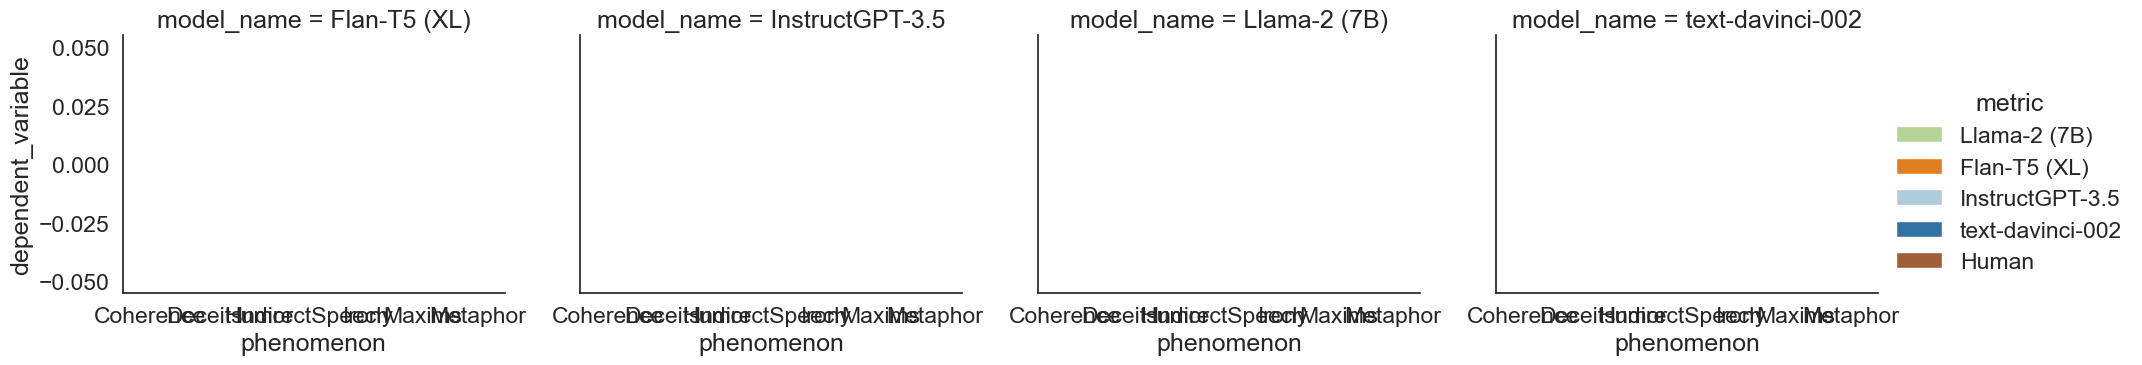

In [79]:
import matplotlib.lines as mlines

def plot_accuracy(df):
    PHEN_ORDER = sorted(df.phenomenon.unique())
    ax = sns.catplot(
        data=df, 
        x="phenomenon", 
        y="dependent_variable", 
        hue="metric", 
        hue_order=MODEL_ORDER, 
        palette=PAL, 
        col="model_name",  # Faceting by model_name here
        kind="bar",
        height=4,
        aspect=1.2,
        order=PHEN_ORDER, 
        #**ERR_STYLE  # Assuming ERR_STYLE is a dictionary with valid arguments
    )
    ax.set_xlabel("")
    ax.set_ylabel("Proportion correct")
    handles, labels = ax.get_legend_handles_labels()
    handles.append(mlines.Line2D([], [], **CHANCE_STYLE))
    labels.append("Random")
    ax.legend(handles, labels, title="", loc='center left', bbox_to_anchor=(1, 0.5))
    plt.gcf().set_size_inches(18,4)
    
    n_phen = len(PHEN_ORDER)
    for i, phen in enumerate(PHEN_ORDER):
        # Draw different random baseline for each task
        ax.axhline(y=CHANCE[phen], xmin=(1/n_phen)*i + 0.01, xmax=(1/n_phen)*(i+1) - 0.01, **CHANCE_STYLE)
    
plot_accuracy(df_summary_plot)
render("all_accuracy_summary.pdf")

/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_76078/3466792182.py:9: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  g = sns.catplot(


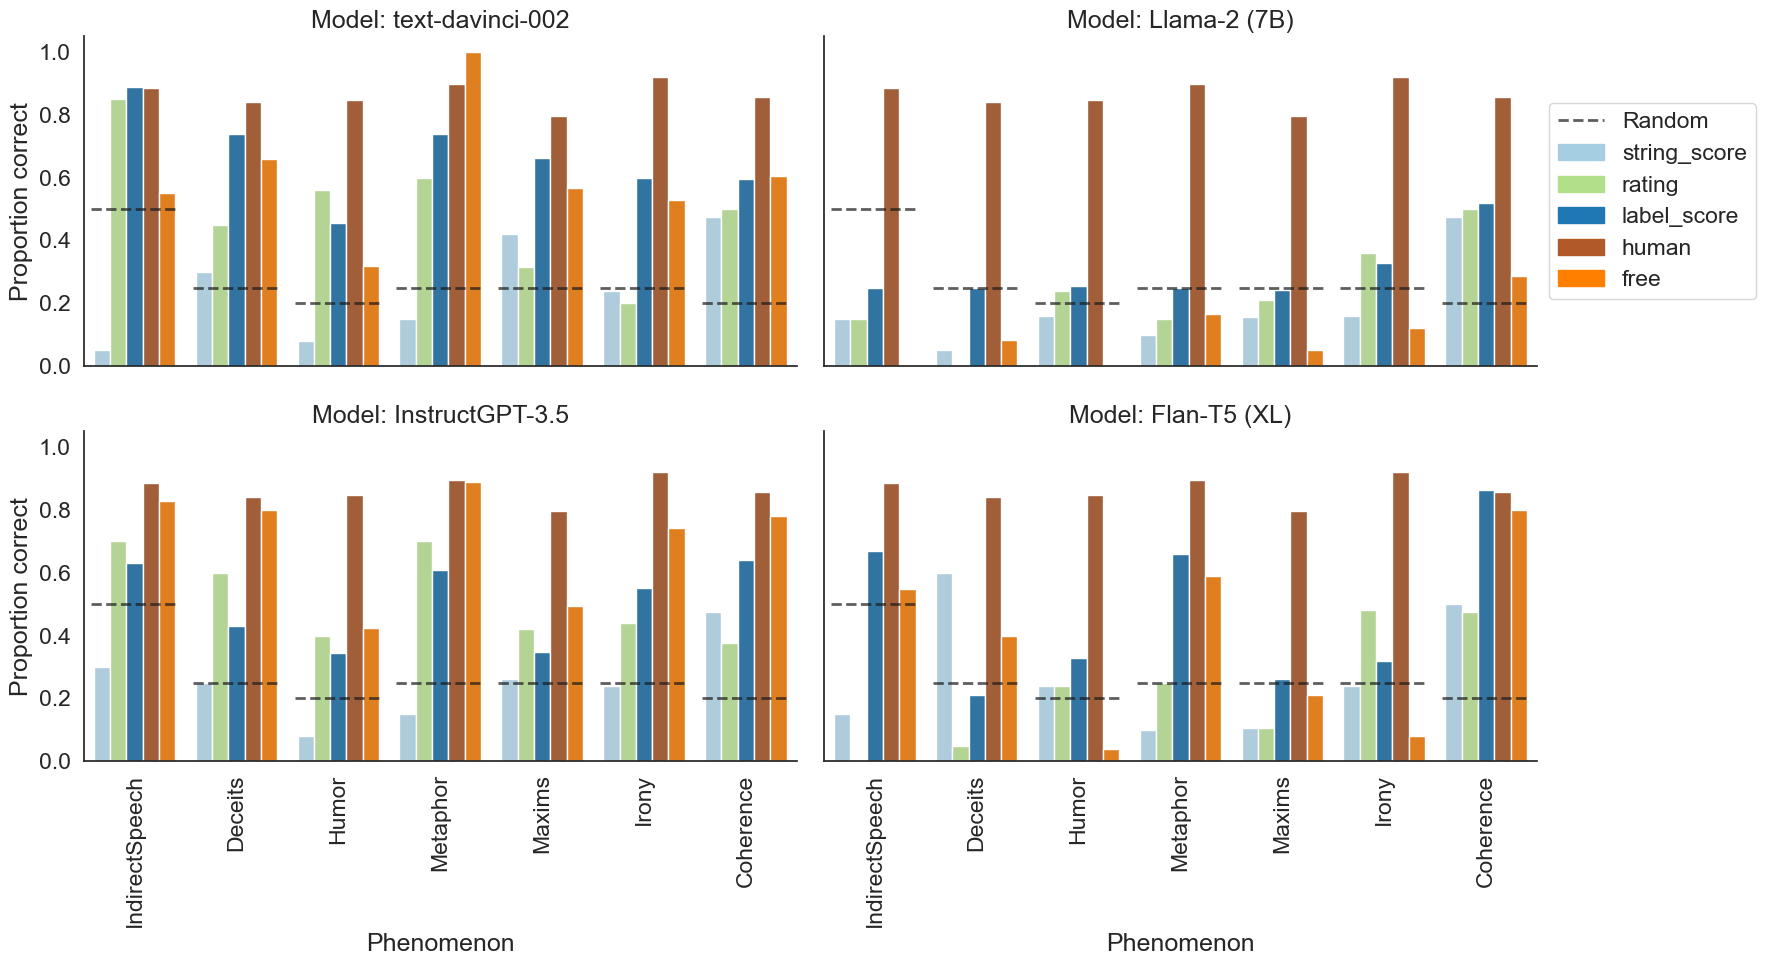

In [180]:
import matplotlib.patches as mpatches

PHEN_ORDER = sorted(df_summary_plot.phenomenon.unique())

# Sorting the DataFrame based on the absolute values of 'dependent_variable'
df_summary_plot.sort_values(by=['metric', 'dependent_variable'], ascending=[False, True], inplace=True)
                            

g = sns.catplot(
    data=df_summary_plot, 
    x="phenomenon", 
    y="dependent_variable", 
    hue="metric", 
    #hue_order=MODEL_ORDER, 
    palette=PAL_METRIC, 
    col="model_name",  # Faceting by model_name here
    col_wrap=2,  # Optional: number of columns when wrapping facets
    kind="bar",
    height=4,
    aspect=0.8,
    legend=False,
    #order=PHEN_ORDER, 
    **ERR_STYLE  # Assuming ERR_STYLE is a dictionary with valid arguments
)

g.fig.set_size_inches(18, 10)
g.set_axis_labels("Phenomenon", "Proportion correct")
g.set_titles("Model: {col_name}")

# Rotate x-axis labels for each subplot
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Iterating over each Axes object (facet) in your catplot
for ax in g.axes.flat:
    n_phen = len(PHEN_ORDER)
    
    for i, phen in enumerate(PHEN_ORDER):
        # Draw different random baseline for each task
        ax.axhline(y=CHANCE[phen], xmin=(1/n_phen)*i + 0.01, xmax=(1/n_phen)*(i+1) - 0.01, **CHANCE_STYLE)

# Assuming adding_labels and adding_handles are lists or arrays
# and PAL_METRIC is a dictionary or something that maps metrics to colors/styles
adding_labels = df_summary_plot['metric'].unique()  # Ensure this is a list or array
adding_handles = [mpatches.Patch(color=PAL_METRIC[label], label=label) for label in adding_labels]


# Handling the legend
ax = g.facet_axis(2, 1)
handles, labels = ax.get_legend_handles_labels()
handles.append(mlines.Line2D([], [], **CHANCE_STYLE))
labels.append("Random")

# Appending adding_labels and adding_handles to labels and handles
labels.extend(adding_labels)
handles.extend(adding_handles)

# Set up legend
ax.legend(handles, labels, title="", loc='center left', bbox_to_anchor=(1, 0.5))
#plt.gcf().set_size_inches(18,4)

# Move the legend to the right outside of the plot area
#g._legend.set_bbox_to_anchor((1.25, 0.6))
#g._legend.set_frame_on(True)
#g._legend.set_title("Metrics")

plt.tight_layout()
plt.show()


/var/folders/jc/6ctllcx143xbrgx01x69skg80000gn/T/ipykernel_76078/432373509.py:9: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1}` instead.

  g = sns.catplot(


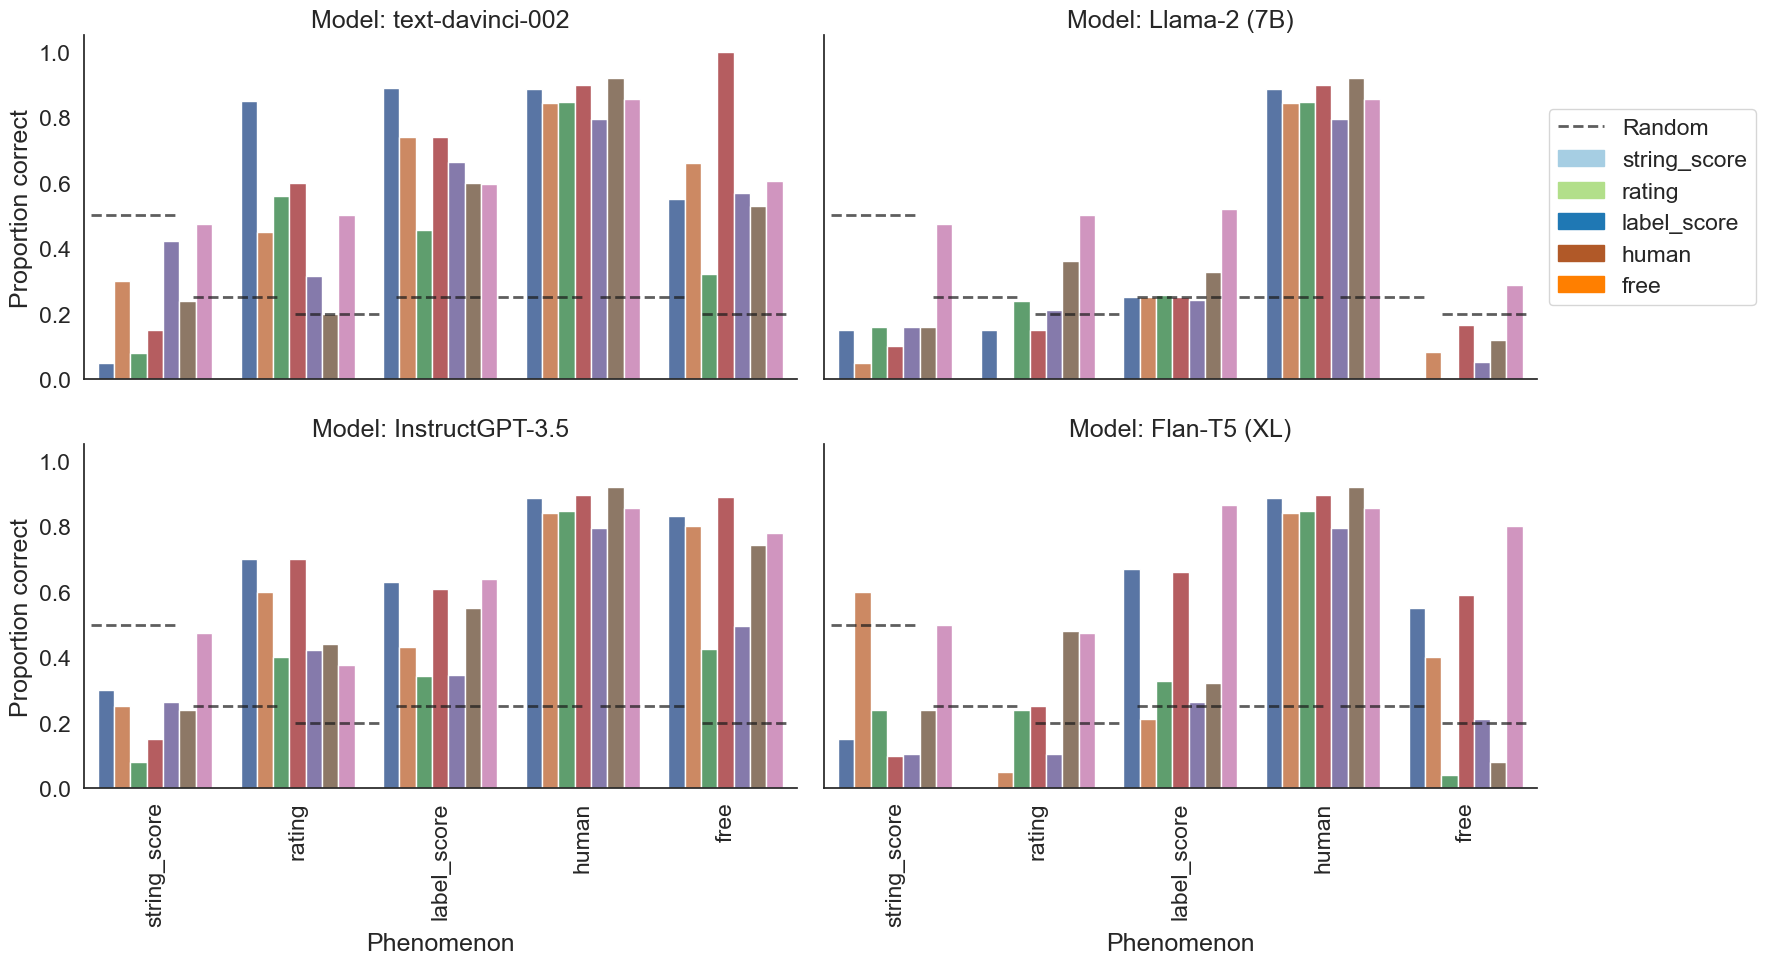

In [184]:
import matplotlib.patches as mpatches

PHEN_ORDER = sorted(df_summary_plot.phenomenon.unique())

# Sorting the DataFrame based on the absolute values of 'dependent_variable'
df_summary_plot.sort_values(by=['metric', 'dependent_variable'], ascending=[False, True], inplace=True)
                            

g = sns.catplot(
    data=df_summary_plot, 
    x="metric", 
    y="dependent_variable", 
    hue="phenomenon", 
    #hue_order=MODEL_ORDER, 
    #palette=PAL_METRIC, 
    col="model_name",  # Faceting by model_name here
    col_wrap=2,  # Optional: number of columns when wrapping facets
    kind="bar",
    height=4,
    aspect=0.8,
    legend=False,
    #order=PHEN_ORDER, 
    **ERR_STYLE  # Assuming ERR_STYLE is a dictionary with valid arguments
)

g.fig.set_size_inches(18, 10)
g.set_axis_labels("Phenomenon", "Proportion correct")
g.set_titles("Model: {col_name}")

# Rotate x-axis labels for each subplot
for ax in g.axes.flat:
    for label in ax.get_xticklabels():
        label.set_rotation(90)

# Iterating over each Axes object (facet) in your catplot
for ax in g.axes.flat:
    n_phen = len(PHEN_ORDER)
    
    for i, phen in enumerate(PHEN_ORDER):
        # Draw different random baseline for each task
        ax.axhline(y=CHANCE[phen], xmin=(1/n_phen)*i + 0.01, xmax=(1/n_phen)*(i+1) - 0.01, **CHANCE_STYLE)

# Assuming adding_labels and adding_handles are lists or arrays
# and PAL_METRIC is a dictionary or something that maps metrics to colors/styles
adding_labels = df_summary_plot['metric'].unique()  # Ensure this is a list or array
adding_handles = [mpatches.Patch(color=PAL_METRIC[label], label=label) for label in adding_labels]


# Handling the legend
ax = g.facet_axis(2, 1)
handles, labels = ax.get_legend_handles_labels()
handles.append(mlines.Line2D([], [], **CHANCE_STYLE))
labels.append("Random")

# Appending adding_labels and adding_handles to labels and handles
labels.extend(adding_labels)
handles.extend(adding_handles)

# Set up legend
ax.legend(handles, labels, title="", loc='center left', bbox_to_anchor=(1, 0.5))
#plt.gcf().set_size_inches(18,4)

# Move the legend to the right outside of the plot area
#g._legend.set_bbox_to_anchor((1.25, 0.6))
#g._legend.set_frame_on(True)
#g._legend.set_title("Metrics")

plt.tight_layout()
plt.show()


In [170]:
df_summary_plot

,model_name,phenomenon,metric,dependent_variable
133,text-davinci-002,Coherence,string_score,0.475000
126,Llama-2 (7B),Coherence,string_score,0.475000
119,InstructGPT-3.5,Coherence,string_score,0.475000
112,Flan-T5 (XL),Coherence,string_score,0.500000
127,Llama-2 (7B),Deceits,string_score,0.050000
...,...,...,...,...
49,text-davinci-002,Maxims,free,0.568421
52,Llama-2 (7B),Metaphor,free,0.166667
50,Flan-T5 (XL),Metaphor,free,0.590000
51,InstructGPT-3.5,Metaphor,free,0.890000


In [181]:
# Define the path to save the plot as PDF
save_path = "plots/corecctness_metrics_model_task.pdf"

# Ensure the directory exists
os.makedirs(os.path.dirname(save_path), exist_ok=True)

# Save the plot to the specified path
g.savefig(save_path, bbox_inches='tight')

save_path


'plots/corecctness_metrics_model_task.pdf'

# Export CSV files for further analysis

In total of two CSVs need to be exported:
* all_summary: contains normalised proportion of correctness given the best config from the associated metric, aggregated by model, phenomenon, and metric
* all_raw: contains raw data of binary response given items, aggregated by model, phenomenon, seed (if availible), and metric

## Export summary data

In [191]:
df_summary_plot.rename(columns={'dependent_variable' : 'accuracy'}, inplace=True)
df_summary_plot
# Save csv file
summary_out_path = "processed_data/all_accuracy_summary.csv"

# Ensure the directory exists
os.makedirs(os.path.dirname(summary_out_path), exist_ok=True)

# Save the csv to the specified path
df_summary_plot.to_csv(summary_out_path, index=False)

## Export raw data

In [200]:
# Define raw_path
raw_label_score_path = "processed_data/label_scores_argmax_wide.csv"

raw_string_score_path = "processed_data/string_scores_argmax_wide.csv"

raw_free_path = "processed_data/free_accuracy_wide.csv"

raw_rating_path = "processed_data/rating_accuracy_wide.csv"

# Read the csv file into a pandas dataframe


df_string_score_raw = pd.read_csv(raw_string_score_path)

df_free_raw = pd.read_csv(raw_free_path)

df_rating_raw = pd.read_csv(raw_rating_path)

In [206]:
# Clean up df_label_score_raw
df_label_score_raw = pd.read_csv(raw_label_score_path)
df_label_score_raw.drop(columns=['sentence_cond_probs','mean_sentence_cond_probs','sentence_surprisal','mean_sentence_surprisal','sentence_mi_surprisal'], inplace=True)
df_label_score_raw.rename(columns={'sentence_mi': 'dependent_variable'}, inplace=True)
df_label_score_raw

,model_name,item_id,phenomenon,metric,dependent_variable
0,google/flan-t5-xl,1,coherence,label_score,1
1,google/flan-t5-xl,1,coherence,label_score,1
2,google/flan-t5-xl,1,deceits,label_score,0
3,google/flan-t5-xl,1,deceits,label_score,0
4,google/flan-t5-xl,1,humour,label_score,0
...,...,...,...,...,...
6755,text-davinci-002,38,coherence,label_score,1
6756,text-davinci-002,39,coherence,label_score,0
6757,text-davinci-002,39,coherence,label_score,1
6758,text-davinci-002,40,coherence,label_score,1


In [214]:
# Clean up df_string_score_raw
df_string_score_raw = pd.read_csv(raw_string_score_path)
df_string_score_raw.drop(columns=['sentence_cond_probs','mean_sentence_cond_probs','sentence_surprisal','sentence_mi','sentence_mi_surprisal'], inplace=True)
df_string_score_raw.rename(columns={'mean_sentence_surprisal': 'dependent_variable'}, inplace=True)
df_string_score_raw

,model_name,item_id,phenomenon,metric,dependent_variable
0,google/flan-t5-xl,1,coherence,string_score,1
1,google/flan-t5-xl,1,deceits,string_score,1
2,google/flan-t5-xl,1,humour,string_score,0
3,google/flan-t5-xl,1,indirect_speech,string_score,0
4,google/flan-t5-xl,1,irony,string_score,0
...,...,...,...,...,...
671,text-davinci-002,36,coherence,string_score,0
672,text-davinci-002,37,coherence,string_score,0
673,text-davinci-002,38,coherence,string_score,1
674,text-davinci-002,39,coherence,string_score,1
